# Project Assignment 3: Stance detecion

Write the code to implement a classifier that determines whether a given comment expresses a pro-vaccination or anti-vaccination stance. 

Initially, you will work with a small sample that you can use to get things set up. Eventually, you will receive the full dataset: first including the result of the first annotation, and later the result of the second round. Please note that your results may change (e.g. which model performs best) when you switch from the small sample to the full dataset.

In your implementation, you are free to use any machine learning approach you think could be useful: the only restriction is that you are not allowed to use existing implementations that carry out exactly this task (that is: classifying whether a text is pro- or anti-vaccine). You may take some inspiration from the document classification examples shown in Lecture 4. However, it is probably useful to try to improve over this solution. For instance, you may read more about the TfidfVectorizer and see what you can do with it.

---
Then write a report detailing your implementation, your experiments and analysis. In particular, some useful issues to discuss might include:

1. How much consensus is there between annotators of the dataset? Do you think the data is reliable?
2. How do you represent your data as features?
3. Did you process the features in any way?
4. How did you select which learning algorithms to use?
5. Did you try to tune the hyperparameters of the learning algorithm, and in that case how?
6. How do you evaluate the quality of your system?
7. How well does your system compare to a trivial baseline?
8. Can you say anything about the errors that the system makes? For a classification task, you may consider a confusion matrix. It is also probably meaningful to include selected errors and comment on what might have gone wrong.
9. Is it possible to say something about which features the model considers important? (Whether this is possible depends on the type of classifier you are using.)

---
MUST INSTALL THIS KRIPPENDORFF TO RUN LATER

In [ ]:
pip install krippendorff

In [150]:
# IMPORTING ALL NECESSARY PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
from collections import Counter
from time import time
import re
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import krippendorff

# Some Settings:
dpi = 100
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x) #control pandas float format

### Import Data

Import data

In [3]:
#raw_data1 = pd.read_csv('a3_train_round1.tsv', sep='\t', names=['Y','Comment'])
#raw_data = pd.read_csv('a3_first_sample.tsv', sep='\t', names=['Y','Comment'])
train = pd.read_csv('a3_train_final.tsv', sep='\t', names=['Y','Comment'])
test = pd.read_csv('a3_test_final.tsv', sep='\t', names=['Y','Comment'])

Peak at data

In [4]:
len(train)

26197

In [5]:
train.head(5)

,Y,Comment
0,0/-1,It is easier to fool a million people than it...
1,0/0,NATURAL IMMUNITY protected us since evolutio...
2,0/-1,NATURAL IMMUNITY protected us since evolutio...
3,1/1/1/-1,The bigest sideffect of vaccines is fewer dea...
4,1/-1,Unvaccinated people are more likely to become...


### Replace multiple annotations with one label in train data

Here we are using a strict labeling methodology only utilising comments with unified annotations explained in the code comments

In [6]:
# STRICT - Assigns the label as either pro = '1' or anti = '0'
# assign the final label as 1 when all annotations are 1 and 
# assign the final label as 0 when all annotations are 0, 
# and assign the rest as -1 and exclude those from final dataframe (e.g. '0/1/0')
# Comments with only 1 annotation will be excluded since they have not been controlled 
proList = ['1/1','1/1/1/1','1/1/1','1/1/1/1/1','1/1/1/1/1/1','1/1/1/1/1/1/1/1/1']
antiList = ['0/0','0/0/0','0/0/0/0','0/0/0/0/0','0/0/0/0/0/0/0/0/0','0/0/0/0/0/0','0/0/0/0/0/0/0','0/0/0/0/0/0/0/0','0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0','0/0/0/0/0/0/0/0/0/0/0/0/0', '0/0/0/0/0/0/0/0/0/0/0/0/0/0','0/0/0/0/0/0/0/0/0/0/0/0','0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0','0/0/0/0/0/0/0/0/0/0','0/0/0/0/0/0/0/0/0/0/0','0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0','0/0/0/0/0/0/0/0/0/0/0/0/0/0/0']

def strict_labelling(df):
    df['Y'] = np.where((df.Y.isin(proList)), '1',
              np.where((df.Y.isin(antiList)),'0' , '-1'))
    label_c = Counter(df['Y'])
    new_df = df[df['Y'] != '-1']
    return new_df, label_c, df

train_strict, label_count_strict = strict_labelling(train)
print(label_count_strict)
train_strict.head(5)

Counter({'1': 10791, '0': 10491, '-1': 4915})


,Y,Comment
1,0,NATURAL IMMUNITY protected us since evolutio...
5,1,Vaccine takes more than a year to develop. T...
6,0,YES IM A TRUCKER FROM USA AND I WONT GET VACC...
8,1,out of anger People say stupid things man is ...
10,0,... vaccines are safe and effective. Why? Beca...


Check impact of size on train data after reduction of ambigious comments

In [7]:
# size of data before removing ambigious comments
print("Original size of train data:\t",sum(list(label_count_strict.values())))
print("Excluding ambigious comments:\t", len(train_strict))

Original size of train data:	 26197
Excluding ambigious comments:	 21282


### Krippendorff alpha test to review agreement among annotaters

In [148]:
# Import raw train data again
train_original = pd.read_csv('a3_train_final.tsv', sep='\t', names=['Y','Comment'])

train_original['Y'] = np.where((train_original.Y.isin(proList)), 1,
          np.where((train_original.Y.isin(antiList)),0 , -1))

In [149]:
import krippendorff

df_L = list(train_original.Y)
df_L.sort()

bigL =[]

for i in df_L:
    if i == 1 or i == 0:
         bigL.append(list([1,0]))
    elif i == -1:
        bigL.append(list([1,1]))

krippendorff.alpha(bigL)

0.6840387109776054

Result within OK interval (66,6-80%)

### Preprocessing 
Here we take the Comments column and create additional columns (features) for both train and test data.
- cleaned, 
- stemmed, 
- lemmatized, 
- exclude stop-words 
- exclude short words 
- exclude both short and stopwords 
- add string lenght
- add word count
- add proportion of capital letters used in text

In [8]:
# PREPROCESSING
def stem(df, ps, org_col_name, new_col_name):
    """Stemming words returns dataframe"""
    df.loc[:, new_col_name] = df[org_col_name].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
    return df


def wordnet_tag(word):
    """Map the first position tag to the first one that lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN,
                "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize(df, wnl, org_col_name, new_col_name):
    """Lemmatizer, returns dataframe"""
    df.loc[:, new_col_name] = df[org_col_name].apply(lambda x: ' '.join([wnl.lemmatize(w, wordnet_tag(w)) for w in nltk.word_tokenize(x.lower())]))
    return df


def preprocessing(dataframe):
    df = dataframe.copy()
    
    # Count duplicates, count and remove
    dup_count = df['Comment'].duplicated().sum()
    # Drop duplicates
    df['Comment'].drop_duplicates()

    # CLEANING
        
    # Make lower case
    df['Cleaned'] = df['Comment'].str.lower()
    # Remove all emojis
    df['Cleaned'] = df['Comment'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE, regex=True)
    # Remove all formatting stuff (phrases between the symbols < and >)
    df['Cleaned'] = df['Cleaned'].str.replace("<.*>", ' ', regex=True).str.strip()
    # Remove any remaining hyperlinks
    df['Cleaned'] = df['Cleaned'].str.replace(r' *https?://[^\s]+', ' ', regex=True).str.strip()
    df['Cleaned'] = df['Cleaned'].str.replace(r'https?://[^\s]+', ' ', regex=True).str.strip()
    # Convert accented (ex. é) characters to normal
    df['Cleaned'] = df['Cleaned'].str.normalize('NFKD')
    # Remove punctuation
    df['Cleaned'] = df['Cleaned'].str.replace('!', ' ',regex=True)
    df['Cleaned'] = df['Cleaned'].str.replace('"', ' ',regex=True)
    df['Cleaned'] = df['Cleaned'].str.replace(':', ' ',regex=True)
    df['Cleaned'] = df['Cleaned'].str.replace('\.', ' ',regex=True)
    df['Cleaned'] = df['Cleaned'].str.replace(',', ' ',regex=True)
    df['Cleaned'] = df['Cleaned'].str.replace("'", '',regex=True)
    df['Cleaned'] = df['Cleaned'].str.replace('[^\w\s]', '',regex=True)
    # Remove leadning, trailing and multiple internal spaces
    df['Cleaned'] = df['Cleaned'].str.replace('\s+', ' ', regex=True).str.strip()
    # Remove unwanted characters, numbers and symbols
    df['Cleaned'] = df['Cleaned'].str.replace("[^a-zA-Z#]", ' ', regex=True)
    
    # Import stopwords with scikit-learn
    stop = text.ENGLISH_STOP_WORDS
    # Remove stopwords
    df['Clean-NoStopWords'] = df['Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # Remove short words longer than 3 characters
    df['Clean-NoShortWords'] = df['Cleaned'].str.replace(r'\b(\w{1,3})\b', '', regex=True)

    # Remove both Short and stop words
    df['Clean-NoStop-NoShort'] = df['Clean-NoShortWords'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # Implement a stemmer
    ps = PorterStemmer()
    # Stem words from cleaned column into new column
    df = stem(df, ps, 'Cleaned', 'Stemmed')

    # Implement a lemmatizer
    wnl = WordNetLemmatizer()
    # lemmatiz and words from cleaned column into new column
    df = lemmatize(df, wnl, 'Cleaned', 'Lemmatized')

    # Create new columns with the length comment and word count
    df['StrLen'] = df['Comment'].str.len() # Amount of characters of full review incl. space
    df['WordCount'] = df['Comment'].str.split().str.len() # Amount of words in review

    # Create new column with rate of capital letters
    # Capital letters should be more connected with strong emotions
    df['NUpper'] = df['Comment'].str.findall(r'[A-Z]').str.len()
    df['NLower'] = df['Comment'].str.findall(r'[a-z]').str.len()
    df['UpperRate'] = df['NUpper'] / (df['NUpper'] + df['NLower'])
    df = df.drop(['NUpper', 'NLower'], axis=1) # Drop unneccesary columns
    
    return df, dup_count

In [9]:
# preprocess train and test data
preprocessed_train_strict, dup_count_train_strict = preprocessing(train_strict)
preprocessed_test, dup_count_test = preprocessing(test)

# peak at train data
preprocessed_train_strict.head(1)

,Y,Comment,Cleaned,Clean-NoStopWords,Clean-NoShortWords,Clean-NoStop-NoShort,Stemmed,Lemmatized,StrLen,WordCount,UpperRate
1,0,NATURAL IMMUNITY protected us since evolutio...,NATURAL IMMUNITY protected us since evolution ...,NATURAL IMMUNITY protected evolution Do exist ...,NATURAL IMMUNITY protected since evolution ...,NATURAL IMMUNITY protected evolution exist any...,natur immun protect us sinc evolut do not exis...,natural immunity protect u since evolution do ...,70,10,0.28


### Some exploratory analysis
Check if there is imbalance between labels

In [10]:
# check balance of labels
print("Train strict:",Counter(preprocessed_train_strict['Y']),"Total:",len(preprocessed_train_strict))
print("Test:",Counter(preprocessed_test['Y']),"Total:",len(preprocessed_test))

Train strict: Counter({'1': 10791, '0': 10491}) Total: 21282
Test: Counter({1: 568, 0: 568}) Total: 1136


Check for null values after all preprocessing and handle

In [11]:
print("Train strict:",preprocessed_train_strict.isnull().values.any())
print("Test:",preprocessed_test.isnull().values.any())

Train strict: True
Test: False


In [12]:
def nans(df): 
    return df[df.isnull().any(axis=1)]

In [13]:
nans(preprocessed_train_strict)

,Y,Comment,Cleaned,Clean-NoStopWords,Clean-NoShortWords,Clean-NoStop-NoShort,Stemmed,Lemmatized,StrLen,WordCount,UpperRate
26187,1,💉💪,,,,,,,2,1,NaN


In [15]:
preprocessed_train_strict['UpperRate'] = preprocessed_train_strict['UpperRate'].fillna(0)
print("Train strict:",preprocessed_train_strict.isnull().values.any())

Train strict: False


Null values handled by replacing with 0 value since not containing any capital letters.

Save to csv file to avoid re-running processing evevery time

In [16]:
# SAVE DF TO CSV TO AVOID RUNNING PREPROCESSING AGAIN
preprocessed_train_strict.to_csv('preprocessed_train_strict.csv', index=False)
preprocessed_test.to_csv('preprocessed_test.csv', index=False)

Check statistical values of numerical columns to better understand data

In [17]:
preprocessed_train_strict.describe()

,StrLen,WordCount,UpperRate
count,21282.00,21282.00,21282.00
mean,136.20,24.75,0.06
std,162.09,28.54,0.13
min,2.00,1.00,0.00
25%,61.00,11.00,0.02
50%,102.00,19.00,0.03
75%,170.00,31.00,0.05
max,8137.00,1230.00,1.00


In [18]:
preprocessed_test.describe()

,Y,StrLen,WordCount,UpperRate
count,1136.00,1136.00,1136.00,1136.00
mean,0.50,114.00,21.01,0.06
std,0.50,82.77,15.01,0.12
min,0.00,10.00,2.00,0.00
25%,0.00,54.75,10.00,0.02
50%,0.50,96.00,18.00,0.03
75%,1.00,150.00,28.00,0.05
max,1.00,895.00,156.00,1.00


## Starting to test for best vectorizors, features and models

- Test these columns: Comments / Cleaned / Clean-NoStopWords / Clean-NoShortWords / Clean-NoShort-NoStop / Stemmed / Lemmatized
- Test different n-grams
- Test both: CountVectorizer & TfidfVectorizer
- Test multiple models
- Test different hyperparameters with GridSearchCV

---
Start by importing preprocessed data files for training and test

In [45]:
# import data
train_full = pd.read_csv('preprocessed_train_strict.csv')
test_full = pd.read_csv('preprocessed_test.csv')

# make smaller train sample
train = train_full.sample(n=2500, replace=False, random_state=1)

# break out X and Y from TRAIN
Xtrain = train.drop(['Y'], axis=1)
Ytrain = train['Y']

# Split TRAIN data into TRAIN and VALIDATION sets
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.20, random_state=42)

# break out X and Y from TEST
Xtest = test_full.drop(['Y'], axis=1)
Ytest = test_full['Y']

In [47]:
train_full.head(1)

,Y,Comment,Cleaned,Clean-NoStopWords,Clean-NoShortWords,Clean-NoStop-NoShort,Stemmed,Lemmatized,StrLen,WordCount,UpperRate
0,0,NATURAL IMMUNITY protected us since evolutio...,NATURAL IMMUNITY protected us since evolution ...,NATURAL IMMUNITY protected evolution Do exist ...,NATURAL IMMUNITY protected since evolution ...,NATURAL IMMUNITY protected evolution exist any...,natur immun protect us sinc evolut do not exis...,natural immunity protect u since evolution do ...,70,10,0.28


In [46]:
test_full.head(1)

,Y,Comment,Cleaned,Clean-NoStopWords,Clean-NoShortWords,Clean-NoStop-NoShort,Stemmed,Lemmatized,StrLen,WordCount,UpperRate
0,1,I don't know what's in it. As if they know wha...,I dont know whats in it As if they know whats ...,I dont know whats As know whats hamburgers eat...,dont know whats they know whats hamburg...,dont know whats know whats hamburgers milk dri...,i dont know what in it as if they know what in...,i dont know whats in it a if they know whats i...,172,32,0.02


### Finding best Feature Column and Vectorizer combination

Combine the two different vectorizers CountVec and Tf-IdfVec with the different feature columns created in the processing step.

In [21]:
vecs = [('cv', CountVectorizer()),('tfidf', TfidfVectorizer())]
columns = ['Comment', 'Cleaned','Stemmed', 'Lemmatized','Clean-NoStopWords','Clean-NoShortWords', 'Clean-NoStop-NoShort']    

In [22]:
def vec_logit_pipeline(vecs, col, Xtrain, Ytrain):
   
    vec_acc = {}
    for v in vecs:
        for c in col:
            # pipe
            pipe = Pipeline([ v, ('logit', LogisticRegression()) ])

            # train
            pipe.fit(Xtrain[c].values.astype('U'), Ytrain)

            # evaluate with cross validation 5-fold
            cv_score = cross_val_score(pipe, Xtrain[c].values.astype('U'), Ytrain, cv=5).mean()
            
            vec_acc.update({(v,c):cv_score})
    
    return vec_acc

In [23]:
vec_col_scores = vec_logit_pipeline(vecs, columns, Xtrain, Ytrain)

In [24]:
# print result
for k,v in vec_col_scores.items():
    print(k,v)

best_vec_col = max(vec_col_scores, key=vec_col_scores.get)
best_col = best_vec_col[1]
best_vec = best_vec_col[0]
best_vec_col_score = max(vec_col_scores.values())

print("\nBest Vectoriser and Column:",best_vec_col,"Mean Cross-Val (train) Score:",best_vec_col_score)

(('cv', CountVectorizer()), 'Comment') 0.757
(('cv', CountVectorizer()), 'Cleaned') 0.751
(('cv', CountVectorizer()), 'Stemmed') 0.7665
(('cv', CountVectorizer()), 'Lemmatized') 0.7595000000000001
(('cv', CountVectorizer()), 'Clean-NoStopWords') 0.7515
(('cv', CountVectorizer()), 'Clean-NoShortWords') 0.74
(('cv', CountVectorizer()), 'Clean-NoStop-NoShort') 0.74
(('tfidf', TfidfVectorizer()), 'Comment') 0.7629999999999999
(('tfidf', TfidfVectorizer()), 'Cleaned') 0.7609999999999999
(('tfidf', TfidfVectorizer()), 'Stemmed') 0.7765
(('tfidf', TfidfVectorizer()), 'Lemmatized') 0.7769999999999999
(('tfidf', TfidfVectorizer()), 'Clean-NoStopWords') 0.75
(('tfidf', TfidfVectorizer()), 'Clean-NoShortWords') 0.742
(('tfidf', TfidfVectorizer()), 'Clean-NoStop-NoShort') 0.7424999999999999

Best Vectoriser and Column: (('tfidf', TfidfVectorizer()), 'Lemmatized') Mean Cross-Val (train) Score: 0.7769999999999999


Also evaluating performance of numerical columns created

In [25]:
def num_logit_pipeline(Xtrain, Ytrain):
   
    # pipe
    pipe = Pipeline([ ('logit', LogisticRegression()) ])

    # train
    pipe.fit(Xtrain, Ytrain)

    # evaluate with cross validation 5-fold
    cv_score = cross_val_score(pipe, Xtrain, Ytrain, cv=5).mean()

    return cv_score

In [26]:
num_Xtrain = Xtrain[['StrLen','WordCount','UpperRate']]
num_col_scores = num_logit_pipeline(num_Xtrain, Ytrain)
print("Mean Cross-Val Score from numerical columns:", num_col_scores)

Mean Cross-Val Score from numerical columns: 0.5369999999999999


The validation accuracy result from numerical columns are far behind the vectorized categorical columns.

### Finding best Classification model

Testing the below default algorithms with the best vectorizer and feature column identified above:
1. Dummy Classifier
2. Logistic Regression
3. Support Vector Classifier
4. Perceptron Classifier
5. Random Forest Classifier
6. Multinomial Naive Bayes Classifier

In [30]:
models = [
        ('dummy',DummyClassifier()),
        ('logit', LogisticRegression()),
        ('svc', SVC()),
        ('per',Perceptron()),
        ('rfc',RandomForestClassifier()),
        ('nb',MultinomialNB()) ]

In [33]:
def tfidf_model_pipeline(models, col, Xtrain, Ytrain):    
    model_acc = {}
    for model in models:
        # pipe
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer()), model])

        # train
        pipe.fit(Xtrain[col].values.astype('U'), Ytrain)

        # evaluate with cross validation 5-fold
        cv_score = cross_val_score(pipe, Xtrain[col].values.astype('U'), Ytrain, cv=5).mean()

        model_acc.update({(model):cv_score})

    return model_acc

In [34]:
model_scores = tfidf_model_pipeline(models, best_col, Xtrain, Ytrain)

In [35]:
# print result
for k,v in model_scores.items():
    print(v,"\t",k)
    
best_model = max(model_scores, key=model_scores.get)
best_model_score =max(model_scores.values())

print("\nBest Model:",best_model,"Mean Cross-Val Score:", best_model_score)

0.5029999999999999 	 ('dummy', DummyClassifier())
0.7769999999999999 	 ('logit', LogisticRegression())
0.7795 	 ('svc', SVC())
0.737 	 ('per', Perceptron())
0.7449999999999999 	 ('rfc', RandomForestClassifier())
0.7859999999999999 	 ('nb', MultinomialNB())

Best Model: ('nb', MultinomialNB()) Mean Cross-Val Score: 0.7859999999999999


### Hyperparameter Tuning for the best models and evaluation on Validation data

We take forward the two models that had the best performance and tune their hyperparameters to try to improve them. We additionally do some feature selection on the vectorized data with selectKbest and finally evaluate on the Validation data set. 

##### Multinomial Naive Bayes

In [36]:
# Setting hyperparameters for Multinomial Naive bayes
mnb_params = {
    'tfidf__ngram_range': [(1,1),(2,2),(3,3),(4,4),(1,1),(1,2),(1,3),(1,4)],
    'nb__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],}

# Logit pipeline setup
mnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()) ])

# GridSearch set up for MNB
mnb_gs = GridSearchCV(mnb_pipe, param_grid=mnb_params, cv=5, n_jobs=-1)

# Fit on train data
mnb_time = time()
mnb_gs.fit(Xtrain[best_col].values.astype('U'), Ytrain)
print("Multinomial Naive Bayes:\nBest train score:", mnb_gs.best_score_,"\nBest params:", mnb_gs.best_params_)

# Evaluate on validation data
mnb_cv_score = mnb_gs.score(Xval[best_col].values.astype('U'), Yval)
print("Validation acc:",mnb_cv_score)

# time
mnb_time = round(time() - mnb_time, 2)
print("Time:",mnb_time)

Multinomial Naive Bayes:
Best train score: 0.794 
Best params: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 3)}
Validation acc: 0.834
Time: 26.33


##### Logistic Regression

In [37]:
# Setting hyperparameters for Logit
logit_params = {
    'tfidf__ngram_range': [(1,1),(2,2),(3,3),(4,4),(1,1),(1,2),(1,3),(1,4)],
    'logit__C': [0.01, 0.1, 1, 10, 100], 
    'logit__tol': [1e-3, 1e-4, 1e-5],
    'logit__penalty': ['l1', 'l2'],
    'logit__solver': ['liblinear']}

# Logit pipeline setup
logit_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logit', LogisticRegression()) ])

# GridSearch set up for Logit
logit_gs = GridSearchCV(logit_pipe, param_grid=logit_params, cv=5, n_jobs=-1)

# Fit on train data
logit_time = time()
logit_gs.fit(Xtrain[best_col].values.astype('U'), Ytrain) 
print("Logistic Regression:\nBest train score:", logit_gs.best_score_,"\nBest params:", logit_gs.best_params_)

# Evaluate on validation data
logit_cv_score = logit_gs.score(Xval[best_col].values.astype('U'), Yval)
print("Validation acc:",logit_cv_score)

# time
logit_time = round(time() - logit_time, 2)
print("Time:",logit_time)

Logistic Regression:
Best train score: 0.779 
Best params: {'logit__C': 100, 'logit__penalty': 'l2', 'logit__solver': 'liblinear', 'logit__tol': 0.001, 'tfidf__ngram_range': (1, 3)}
Validation acc: 0.808
Time: 855.27


##### SVC

In [38]:
# Setting hyperparameters for SVC
svc_params = {
    'tfidf__ngram_range': [(1,1),(2,2),(3,3),(4,4),(1,1),(1,2),(1,3),(1,4)],
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__tol': [1e-3, 1e-4, 1e-5],
    'svc__kernel': ['linear','rbf', 'poly', 'sigmoid']}


# SVC pipeline setup
svc_pipe = Pipeline([
     ('tfidf', TfidfVectorizer()),
     ('svc', SVC()) ])

# GridSearch set up for SVC
svc_gs = GridSearchCV(svc_pipe, param_grid=svc_params, cv=5, n_jobs=-1)

# Fit on train data
svc_time = time()
svc_gs.fit(Xtrain[best_col].values.astype('U'), Ytrain)
print("SVC:\nBest train score:", svc_gs.best_score_,"\nBest params:", svc_gs.best_params_)

# Evaluate on validation data
svc_cv_score = svc_gs.score(Xval[best_col].values.astype('U'), Yval) # evaluate on validation
print("Validation acc:",svc_cv_score)

# time
svc_time = round(time() - svc_time, 2)
print("Time:",svc_time)

SVC:
Best train score: 0.7845 
Best params: {'svc__C': 10, 'svc__kernel': 'rbf', 'svc__tol': 0.001, 'tfidf__ngram_range': (1, 1)}
Validation acc: 0.792
Time: 812.0


##### Best Hyperparameters for MNB

In [91]:
# Best hyperparameters
best_alpha = mnb_gs.best_params_['nb__alpha']
print("Aplha:",best_alpha)
best_ngram = mnb_gs.best_params_['tfidf__ngram_range']
print("Ngram:",best_ngram)

Aplha: 0.1
Ngram: (1, 3)


### Before final testing - Compare distribution of train and test data

In [127]:
# function to calculate TFIDF
def freq_tfidf_cols(df, col): 
    """calculate term frequency - inverse document frequency and return new dataframe"""
    # Get word frequencies with count vectorizer
    cvec = CountVectorizer(ngram_range=(1,2)) #, stop_words='english')
    cvec_trans = cvec.fit_transform(df[col].values.astype('U')) # fit to X set

    # Create a dataframe with term and frequency columns
    freq = np.asarray(cvec_trans.sum(axis=0)).ravel() # format so we can put in a df
    freq_df = pd.DataFrame({'term': cvec.get_feature_names(), 'frequencies': freq})

    # Create a column that ranks in terms of frequencies, most common term get 1 and so on
    freq_df['fq_rank'] = freq_df['frequencies'].rank(method='first', ascending=False).astype('int32')

    # Make probabilities of word frequencies (so that alL words sum to 1), i.e. divide every row by sum of column
    freq_df['fq_prob'] = freq_df['frequencies'] / freq_df['frequencies'].sum()

    # Create TF-IDF word weights with the tfidf-transformer command
    t_trans = TfidfTransformer()
    trans_weights = t_trans.fit_transform(cvec_trans)

    # Create a dataframe with term and TF-IDF weights columns
    weight = np.asarray(trans_weights.mean(axis=0)).ravel()
    weight_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weight})

    # Create a column by the rank of the term's weight, so heaviest term get 1, second heaviest 2 and so on
    weight_df['w_rank'] = weight_df['weight'].rank(method='first', ascending=False).astype('int32')

    # Make probabilities of word frequencies (so that alL words sum to 1), i.e. divide every row by sum of column
    weight_df['w_prob'] = weight_df['weight'] / weight_df['weight'].sum()

    # Merge the frames and display
    # As we can see they are similar but are not exactly the same order
    new_df = freq_df.merge(weight_df, on='term')
    return new_df

In [128]:
# run function for train and validation
df_train = freq_tfidf_cols(train_full, 'Lemmatized')
df_test = freq_tfidf_cols(test_full, 'Lemmatized')

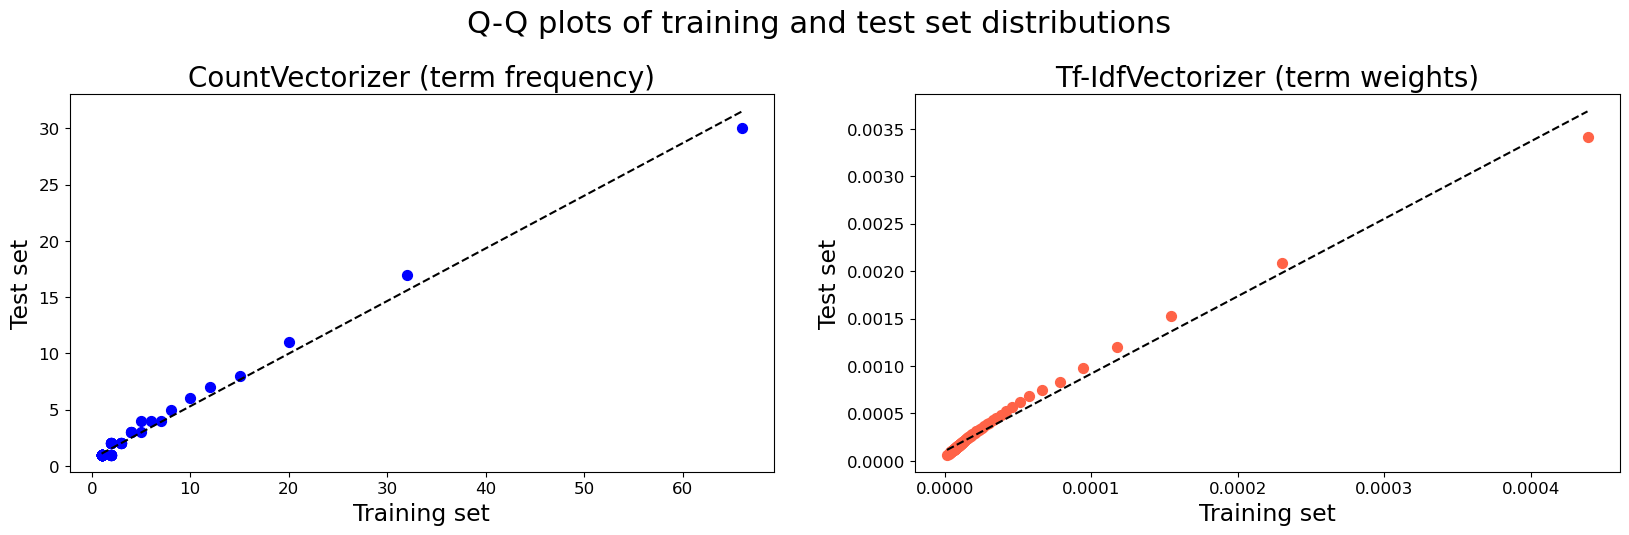

In [129]:
# Do the training and validation set follow the same distribution? Illustrate their relations with a Q-Q plot.
# Create a quantile dataframe
q = [c/100 for c in range(1, 100, 1)]
df_qs = pd.DataFrame({"train_freq": df_train["frequencies"].quantile(q),
                      "train_weight": df_train["weight"].quantile(q),
                      "val_freq": df_test["frequencies"].quantile(q),
                      "val_weight": df_test["weight"].quantile(q)
                     })

# Plot training and validation sets against eachother for frequency and tfidf-weights
fig, axes = plt.subplots(1, 2, figsize=(20, 5), dpi=dpi)
plt.suptitle("Q-Q plots of training and test set distributions", size=22, y=1.05)

axes[0].set_title("CountVectorizer (term frequency)", size=20)
axes[1].set_title("Tf-IdfVectorizer (term weights)", size=20)
df_qs.plot.scatter(x="train_freq", y="val_freq", ax=axes[0], color="blue", marker="o", fontsize=12, s=50)
df_qs.plot.scatter(x="train_weight", y="val_weight", ax=axes[1], color="tomato", marker="o", fontsize=12, s=50)
axes[0].set_xlabel("Training set", size=17)
axes[1].set_xlabel("Training set", size=17)
axes[0].set_ylabel("Test set", size=17)
axes[1].set_ylabel("Test set", size=17)

# Draw fitted line that represents perfect correspondence
pf = np.polyfit(x= df_qs["train_freq"], y= df_qs["val_freq"], deg=1)
pw = np.polyfit(x= df_qs["train_weight"], y=df_qs["val_weight"], deg=1)
fitted_line_freq = pf[1] + pf[0]*df_qs["train_freq"]
fitted_line_weight = pw[1] + pw[0]*df_qs["train_weight"]
axes[0].plot(df_qs["train_freq"], fitted_line_freq, color='k', linestyle="dashed")
axes[1].plot(df_qs["train_weight"], fitted_line_weight, color='k', linestyle="dashed")
plt.show()

Here we are using the training and validation data to check if they follow the same distribution with the help of Q-Q plots. We're only using the x variables "term frequency" (from Count Vectorizer) and "Term frequency-Inverse document frequency" (Tf-Idf). Since the size of the training and validation set is different, the x and the y axes will be different on both plots. But we can see that the distribtuions between the two sets for these variables are very similar and seem to follow the same distribution. Therefore, there should be no issue using these two sets.

### Final Model and Evaluation 

In [92]:
# Get full training data set and break out X and Y from TRAIN
Xtrain_f = train_full.drop(['Y'], axis=1)
Ytrain_f = train_full['Y']
print("Full train:",len(Xtrain_f))
print("Full test:",len(Xtest))

Full train: 21282
Full test: 1136


In [52]:
print("### Final Model: Multinomial Naive Bayes ###")

final_pipe = Pipeline([
     ('tfidf', TfidfVectorizer(ngram_range=best_ngram)),
     ('mnb', MultinomialNB(alpha=best_alpha)) ])

# Fit on train data
final_pipe.fit(Xtrain_f[best_col].values.astype('U'), Ytrain_f)

# Predict on test 
final_pred_labels = final_pipe.predict(Xtest[best_col].values.astype('U'))

# Accuracy on test data 
final_test_acc = accuracy_score(Ytest, final_pred_labels)
print("Final Model Test Accuracy:", final_test_acc)

clf_report = classification_report(Ytest, final_pred_labels)
print("\nClassification report:\n",clf_report)

### Final Model: Multinomial Naive Bayes ###
Final Model Test Accuracy: 0.886443661971831

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88       568
           1       0.88      0.90      0.89       568

    accuracy                           0.89      1136
   macro avg       0.89      0.89      0.89      1136
weighted avg       0.89      0.89      0.89      1136



Compare accuracy score to some baseline null accuracy

In [53]:
# Calculate null accuracy in a single line of code - only for binary classification problems coded as 0/1
null_acc = max(Ytest.mean(), 1 - Ytest.mean())
print(null_acc)

0.5


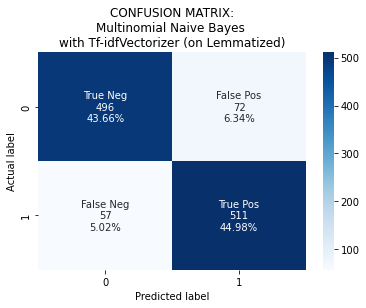

In [57]:
# Confusion Matrix - first argument is true values, second argument is predicted values (2x2 numpy array (matrix))
cf_matrix = confusion_matrix(Ytest, final_pred_labels)

# plot the result in confusion matrix heatmap
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title('CONFUSION MATRIX:\nMultinomial Naive Bayes \nwith Tf-idfVectorizer (on Lemmatized)')
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

Look at features the model found useful wen classifying

In [93]:
# Get the names of each feature from vectorizer
feature_names = final_pipe.named_steps['tfidf'].get_feature_names()

# Get the feature weights from SVC
feature_weights = final_pipe.named_steps['mnb'].coef_[0]

# Print top 10 feature-weights
for w, f in sorted(zip(feature_weights, feature_names))[:25]:
    print(w,"\t",f)

-14.00927942584559 	 aa no
-14.00927942584559 	 aa no vaccine
-14.00927942584559 	 aahhhhh
-14.00927942584559 	 aahhhhh screw
-14.00927942584559 	 aahhhhh screw this
-14.00927942584559 	 aaron
-14.00927942584559 	 aaron about
-14.00927942584559 	 aaron about the
-14.00927942584559 	 aaron die
-14.00927942584559 	 aaron die more
-14.00927942584559 	 aaron die week
-14.00927942584559 	 aaron just
-14.00927942584559 	 aaron just die
-14.00927942584559 	 aaron oh
-14.00927942584559 	 aaron oh wait
-14.00927942584559 	 aaron take
-14.00927942584559 	 aaron take the
-14.00927942584559 	 aaron take vaccine
-14.00927942584559 	 aaron take vax
-14.00927942584559 	 aaron tragic
-14.00927942584559 	 aaron tragic death
-14.00927942584559 	 abandon kid
-14.00927942584559 	 abandon kid pope
-14.00927942584559 	 abandon the development
-14.00927942584559 	 abc


C:\Users\anouk\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [67]:
neg_class_prob_sorted = final_pipe.named_steps['mnb'].feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = final_pipe.named_steps['mnb'].feature_log_prob_[1, :].argsort()[::-1]

print(np.take(final_pipe.named_steps['tfidf'].get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(final_pipe.named_steps['tfidf'].get_feature_names(), pos_class_prob_sorted[:10]))

['the' 'be' 'vaccine' 'it' 'to' 'not' 'and' 'take' 'have' 'you']
['the' 'be' 'get' 'to' 'vaccine' 'and' 'it' 'of' 'my' 'have']


Compare some true and predicted comments

In [69]:
# print the first 25 true and predicted responses
print('True:', Ytest.values[:25])
print('False:', final_pred_labels[:25])

True: [1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1]
False: [0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1]


In [133]:
print("---\nCorrect Label:", Ytest[0],"\nPredicted Label:",final_pred_labels[0],"\n",Xtest['Comment'][0])
print("\n---\nCorrect Label:", Ytest[4],"\nPredicted Label:",final_pred_labels[4],"\n",Xtest['Comment'][4])
print("\n---\nCorrect Label:", Ytest[6],"\nPredicted Label:",final_pred_labels[6],"\n",Xtest['Comment'][6])
print("\n---\nCorrect Label:", Ytest[12],"\nPredicted Label:",final_pred_labels[12],"\n",Xtest['Comment'][12])
print("\n---\nCorrect Label:", Ytest[23],"\nPredicted Label:",final_pred_labels[23],"\n",Xtest['Comment'][23])

---
Correct Label: 1 
Predicted Label: 0 
 I don't know what's in it. As if they know what's in the hamburgers they eat, the milk they drink, the high fructose corn syrup they consume... what a tragedy of stupidity.

---
Correct Label: 0 
Predicted Label: 1 
 Vaccines are saving lives meanwhile romania being the least vaccinated and also least infected country in the whole europe

---
Correct Label: 0 
Predicted Label: 1 
 if you don't have the vaccine, you're robbing someone else their right to live a healthy normal life lmfao My I.Q just dropped 10 points listening to that Bullshit !

---
Correct Label: 0 
Predicted Label: 1 
 11 months on and still no symptoms. I feel great. No vaccine and have been visiting my 91 year old nan who smokes ALOT and she's fine. This is about depopulation a Eugenics program.

---
Correct Label: 1 
Predicted Label: 0 
 A good friend is recovering after covid, having refused vaccination. He is confused and has trouble focusing. He remembers that he wasn't